In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import joblib

In [2]:
df = pd.read_csv("./process_metrics_with_runtime.csv")

In [3]:
# Features and label
features = ["threads", "cpu_percent", "memory_mb", "num_threads", "context_switches", "uptime"]
target = "total_runtime"

In [4]:
X_raw = df[features]
y_raw = df[target]

In [5]:
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

In [6]:
X = torch.tensor(X_scaled, dtype=torch.float32)
y = torch.tensor(y_raw.values, dtype=torch.float32).view(-1, 1)

In [7]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True)

In [8]:
# Create DataLoaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=4, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=4)

In [9]:
# Define the model
class RuntimePredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(X.shape[1], 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        return self.model(x)

model = RuntimePredictor()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Training loop
train_losses = []
val_losses = []

print("Starting training...")
for epoch in range(100):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        output = model(xb)
        loss = loss_fn(output, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            output = model(xb)
            loss = loss_fn(output, yb)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Log progress
    print(f"Epoch {epoch+1}/100 - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

print("✅ Training complete.")


Starting training...
Epoch 1/100 - Train Loss: 211.7099 | Val Loss: 20.9857
Epoch 2/100 - Train Loss: 10.1137 | Val Loss: 2.4317
Epoch 3/100 - Train Loss: 18.1590 | Val Loss: 0.5981
Epoch 4/100 - Train Loss: 9.8508 | Val Loss: 0.4658
Epoch 5/100 - Train Loss: 10.1429 | Val Loss: 0.4199
Epoch 6/100 - Train Loss: 4.7440 | Val Loss: 0.4355
Epoch 7/100 - Train Loss: 1.6531 | Val Loss: 0.4401
Epoch 8/100 - Train Loss: 0.4827 | Val Loss: 0.4999
Epoch 9/100 - Train Loss: 0.3708 | Val Loss: 0.5034
Epoch 10/100 - Train Loss: 0.3685 | Val Loss: 0.3990
Epoch 11/100 - Train Loss: 0.4865 | Val Loss: 0.3925
Epoch 12/100 - Train Loss: 0.3044 | Val Loss: 0.6134
Epoch 13/100 - Train Loss: 0.4823 | Val Loss: 0.4024
Epoch 14/100 - Train Loss: 0.2381 | Val Loss: 0.3763
Epoch 15/100 - Train Loss: 0.5878 | Val Loss: 0.3802
Epoch 16/100 - Train Loss: 0.2466 | Val Loss: 0.3803
Epoch 17/100 - Train Loss: 0.4944 | Val Loss: 0.4812
Epoch 18/100 - Train Loss: 0.2921 | Val Loss: 0.4388
Epoch 19/100 - Train Loss: 0

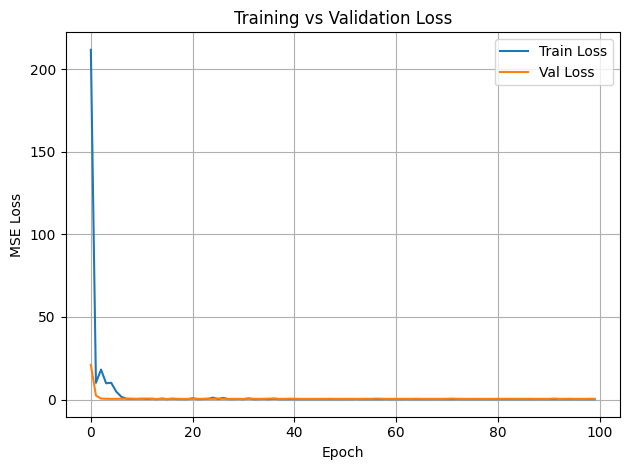

In [10]:
# Plot training and validation loss
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()

In [11]:
# Ensure model is in evaluation mode
model.eval()

# Predict on validation set
with torch.no_grad():
    y_pred = model(X_val).squeeze().numpy()
    y_true = y_val.squeeze().numpy()

# Optional: Convert predictions to a DataFrame
results_df = pd.DataFrame({
    "Actual Runtime": y_true,
    "Predicted Runtime": y_pred
})

# Show first few comparisons
results_df.head(10)

,Actual Runtime,Predicted Runtime
0,11.980000,12.009188
1,86.730003,86.537872
2,88.680000,86.748985
3,86.970001,86.752945
4,24.260000,24.181583
5,88.680000,86.759079
6,9.920000,9.962787
7,9.930000,9.957218
8,87.019997,86.799950
9,86.940002,86.605179


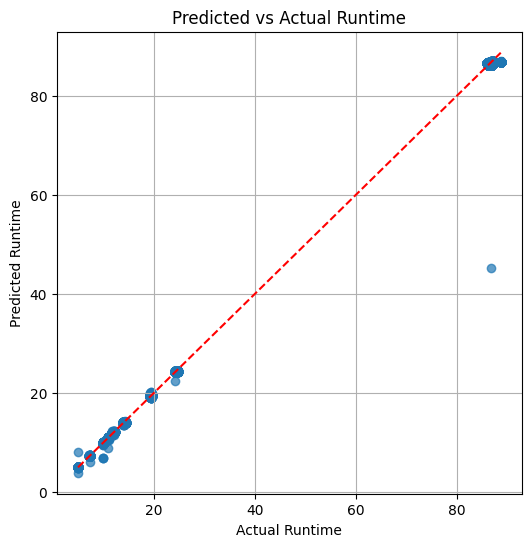

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.7)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')  # Ideal line
plt.xlabel("Actual Runtime")
plt.ylabel("Predicted Runtime")
plt.title("Predicted vs Actual Runtime")
plt.grid(True)
plt.show()


In [14]:
joblib.dump(scaler, "scaler.save")
torch.save(model.state_dict(), "runtime_predictor.pt")